# Image Classification
In this project, we'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. We'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  We'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers.  At the end, we'll get to see your neural network's predictions on the sample images. The code lives [here](https://github.com/tsaqib/ml-playground/tree/master/cnn-tensorflow).

## All the import and initializations

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile
import helper
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import pickle
import tensorflow as tf
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Get the Data
Let us run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [2]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

CIFAR-10 Dataset: 171MB [00:20, 8.28MB/s]                            


All files found!


## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory. The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data. Let us play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

Let us ask ourselves "What are all possible labels?", "What is the range of values for the image data?", "Are the labels in order or random?".  Answers to questions like these will help us preprocess the data and end up with better predictions.


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


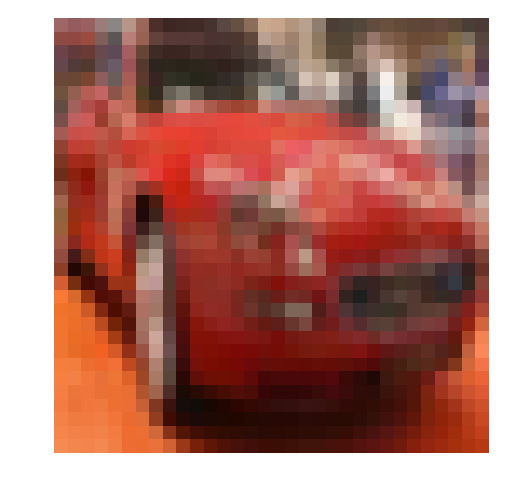

In [3]:
# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
In the cell below, we have to implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [21]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    return x / 255


tests.test_normalize(normalize)

Tests Passed


### One-hot encode
Just like the previous code cell, let us implement a function for preprocessing namely `one_hot_encode`. This function will return the list of labels as One-Hot encoded Numpy array. The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`. We need to make sure to save the map of encodings outside the function.

In [5]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    lb = LabelBinarizer()
    lb.fit(x)
    lb.classes_ = list(range(0, 10))
    return lb.transform(x)


tests.test_one_hot_encode(one_hot_encode)

Tests Passed


### Randomize Data
As we have seen from exploring the data above, the order of the samples are randomized. If needed we could randomize the dataset at this stage, but for this imageset it's already random.

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file.

In [6]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
Next time we come back to this notebook or have to restart the notebook, we can start from here now that the preprocessed data has been saved to disk. Just make sure you imported all the packages by executing the first cell at the beginning.

In [7]:
# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, we'll build each layer into a function. Most of the code we've seen has been outside of functions. To test the code more thoroughly, we require that we put each layer in a function. This allows us to clearly test for simple mistakes using the unittests included in this project.

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. Let us implement the following functions
* Implement `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

These names will be used at the end of the project to load the saved model.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [8]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a bach of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32, shape=[None, *image_shape], name="x")


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.float32, shape=[None, n_classes], name="y")


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32, name="keep_prob")


tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, you should implement the function `conv2d_maxpool` to apply convolution then max pooling:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
 * Same padding can be used, but we're free to use any padding.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.
 * Same padding can be used, but we're free to use any padding.

Note: Let us not use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for this layer just to keep just enough details.

In [9]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    weights = tf.Variable(tf.truncated_normal([*conv_ksize, int(x_tensor.get_shape()[3]), conv_num_outputs], mean=0.0, stddev=0.05, dtype=tf.float32))
    biases = tf.Variable(tf.constant(0, shape=[conv_num_outputs], dtype=tf.float32))
    x = tf.nn.conv2d(x_tensor, weights, strides=[1, *conv_strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, biases)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, ksize=[1, *pool_ksize, 1], strides=[1, *pool_strides, 1], padding='SAME')
    return x


tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer
Let us implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). Let us now use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for this layer.

In [10]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    return tf.contrib.layers.flatten(x_tensor)


tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer
Let us implement the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). You can use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for this layer.

In [11]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    return tf.contrib.layers.fully_connected(x_tensor, num_outputs, activation_fn=tf.nn.relu)


tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer
Let us implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Here we can use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for this layer.

Note: Activation, softmax, or cross entropy shouldn't be applied to this.

In [12]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    return tf.contrib.layers.fully_connected(x_tensor, num_outputs, activation_fn=None)


tests.test_output(output)

Tests Passed


### Create Convolutional Model
Let us implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits. We can use the layers you created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* We can apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [13]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    
    # Apply Convolution and Max Pool layers
    conv_num_outputs = [8*3, 16*3, 32*3]
    conv_ksize, conv_strides, pool_ksize, pool_strides, num_outputs = (3,3), (1,1), (2,2), (2,2), 512

    conv = conv2d_maxpool(x, conv_num_outputs[0], conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv = conv2d_maxpool(conv, conv_num_outputs[1], conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv = conv2d_maxpool(conv, conv_num_outputs[2], conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    # Apply a Flatten Layer
    flattened = flatten(conv)
    
    # Apply Fully Connected Layers
    fully = fully_conn(flattened, num_outputs)
    fc_layer = tf.nn.dropout(fully, keep_prob)
    fully = fully_conn(fc_layer, num_outputs)
    fc_layer = tf.nn.dropout(fully, keep_prob)
    
    return output(fully, 10)


##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization
Now we can implement the function `train_neural_network` to do a single optimization. The optimization uses `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [14]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer, feed_dict={x: feature_batch, y: label_batch, keep_prob: keep_probability})
    
    pass


tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats
Let us implement the function `print_stats` to print loss and validation accuracy. We can use the global variables `valid_features` and `valid_labels` to calculate validation accuracy. Let us also use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [15]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.0})
    validation_accuracy = session.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.0})
    print('Loss: {:>10.4f}, Accuracy: {:.4f}'.format(loss, validation_accuracy))
    
    pass

### Hyperparameters
The following parameters need to be tuned:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for. In most cases, they are set to common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

In [16]:
epochs = 20
batch_size = 512
keep_probability = 0.5

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while we iterate on the model to get a better accuracy. Once the final validation accuracy is 50% or greater, we can run the model on all the data in the next section.

In [17]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.0547, Accuracy: 0.2864
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.8515, Accuracy: 0.3674
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.7292, Accuracy: 0.4026
Epoch  4, CIFAR-10 Batch 1:  Loss:     1.6117, Accuracy: 0.4262
Epoch  5, CIFAR-10 Batch 1:  Loss:     1.6143, Accuracy: 0.4188
Epoch  6, CIFAR-10 Batch 1:  Loss:     1.5106, Accuracy: 0.4368
Epoch  7, CIFAR-10 Batch 1:  Loss:     1.4163, Accuracy: 0.4858
Epoch  8, CIFAR-10 Batch 1:  Loss:     1.3395, Accuracy: 0.5002
Epoch  9, CIFAR-10 Batch 1:  Loss:     1.2774, Accuracy: 0.5200
Epoch 10, CIFAR-10 Batch 1:  Loss:     1.2250, Accuracy: 0.5304
Epoch 11, CIFAR-10 Batch 1:  Loss:     1.1439, Accuracy: 0.5256
Epoch 12, CIFAR-10 Batch 1:  Loss:     1.0572, Accuracy: 0.5578
Epoch 13, CIFAR-10 Batch 1:  Loss:     1.0046, Accuracy: 0.5616
Epoch 14, CIFAR-10 Batch 1:  Loss:     0.9356, Accuracy: 0.5768
Epoch 15, CIFAR-10 Batch 1:  Loss:     0.8826, Accuracy: 0.57

### Fully Train the Model
Now that we got a decent accuracy with a single CIFAR-10 batch, let us try it with all five batches.

In [18]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     1.9996, Accuracy: 0.2956
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.7345, Accuracy: 0.3496
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.5510, Accuracy: 0.3740
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.5498, Accuracy: 0.4014
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.5230, Accuracy: 0.4434
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.5923, Accuracy: 0.4646
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.3865, Accuracy: 0.4736
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.2995, Accuracy: 0.4538
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.2532, Accuracy: 0.5090
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.2698, Accuracy: 0.5192
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.3894, Accuracy: 0.5212
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.2425, Accuracy: 0.5166
Epoch  3, CIFAR-10 Batch 3:  Loss:     1.1189, Accuracy: 0.5384
Epoch  3, CIFAR-10 Batch 4:  Loss:     1.0980, Accuracy: 0.5448
Epoch  3, CIFAR-10 Batch 5:  Loss:     1.1311, Accuracy: 0.5552
Epoch  4, CIFAR-10 Batch 1: 

# Checkpoint
The model has been saved to disk.

## Test Model
Let us test your model against the test dataset. This will be our final accuracy for this project. Should we have an accuracy less than 50%, we need to keep tweaking the model architecture and parameters.

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.7016888797283173



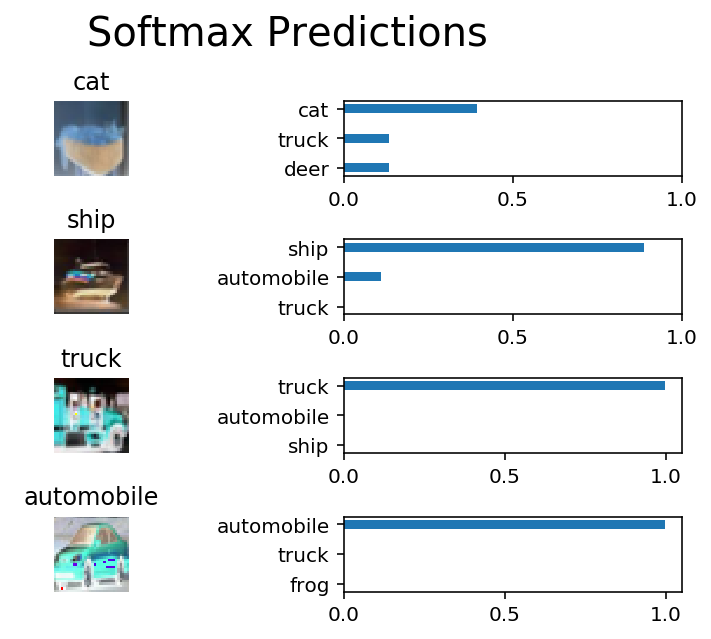

In [22]:
# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Why ~70% Accuracy?
Some say 50% isn't bad for a simple CNN. Pure guessing would get us 10% accuracy for 10 classes. 